 # Frequentist Models for Match Score Prediction



 This notebook demonstrates how to use frequentist statistical models to predict match scores using the `ssat` library.

 ## Importing Libraries



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from ssat.data import get_sample_handball_match_data
from ssat.frequentist import GSSD, BradleyTerry


 ## Understanding the Models



 We'll compare two key frequentist models with different approaches:



 - **Bradley-Terry**: Uses paired comparison approach based on team strengths and logistic regression for win probabilities.

 - **GSSD**: Generalized Scores Standard Deviation model using team offensive/defensive statistics with linear regression.



 The difference is demonstrated in their underlying assumptions and prediction methodologies.

 ## Train-Test Split



 We'll split the data chronologically to evaluate model performance properly.

In [2]:
# Load and prepare data
match_df = get_sample_handball_match_data()

league = "Herre Handbold Ligaen"
seasons = [2024]

filtered_matches = match_df.query("league == @league and season in @seasons")
filtered_matches = filtered_matches.assign(
    spread=filtered_matches.home_goals - filtered_matches.away_goals
)

# Sort by date to ensure chronological split
filtered_matches = filtered_matches.sort_values("datetime")

print(f"Total matches from {league} in {seasons}: {len(filtered_matches)}")
print(
    f"Unique teams: {len(pd.concat([filtered_matches['home_team'], filtered_matches['away_team']]).unique())}"
)
print(
    f"Date range: {filtered_matches['datetime'].min().date()} to {filtered_matches['datetime'].max().date()}"
)


Total matches from Herre Handbold Ligaen in [2024]: 105
Unique teams: 16
Date range: 2024-02-02 to 2024-06-01


In [3]:
split_idx = int(len(filtered_matches) * 0.8)

train_data = filtered_matches.iloc[:split_idx]
test_data = filtered_matches.iloc[split_idx:]

print(
    f"\nTrain set: {len(train_data)} matches ({train_data['datetime'].min().date()} to {train_data['datetime'].max().date()})"
)
print(
    f"Test set: {len(test_data)} matches ({test_data['datetime'].min().date()} to {test_data['datetime'].max().date()})"
)

# Prepare training features and targets
X_train = train_data[["home_team", "away_team"]]
Z_train = train_data[["home_goals", "away_goals"]]
y_train = train_data["spread"]

# Prepare test features and targets (for evaluation)
X_test = test_data[["home_team", "away_team"]]
Z_test = test_data[["home_goals", "away_goals"]]
y_test = test_data["spread"]

# Create match identifiers for test set
test_data = test_data.assign(
    match_id=test_data["home_team"] + " vs " + test_data["away_team"]
)
X_test.index = test_data["match_id"]

print("\nTraining data info:")
print(
    f"Average goals per match: {Z_train[['home_goals', 'away_goals']].sum(axis=1).mean():.1f}"
)
print(f"Average spread: {y_train.mean():.2f} (std: {y_train.std():.2f})")



Train set: 84 matches (2024-02-02 to 2024-04-21)
Test set: 21 matches (2024-04-22 to 2024-06-01)

Training data info:
Average goals per match: 58.3
Average spread: 0.94 (std: 5.10)


 ## Fitting Models



 We will fit two frequentist models on the training data: Bradley-Terry and GSSD.

In [4]:
bt_model = BradleyTerry()
bt_model.fit(X_train, y_train, Z_train)

# Get team ratings
bt_ratings = bt_model.get_team_ratings()
print("Bradley-Terry Team Ratings (Top 10):")
print(bt_ratings.sort_values(by="rating", ascending=False).head(10))

# Make predictions on test set
bt_preds = bt_model.predict(X_test)
bt_probas = bt_model.predict_proba(X_test, point_spread=0, include_draw=True)


Bradley-Terry Team Ratings (Top 10):
                         rating
Skive                  4.595969
Aalborg                2.431931
GOG                    0.876686
Home Advantage         0.552891
Fredericia             0.377130
Skjern                 0.354896
Mors                   0.231346
Ringsted               0.018254
Sonderjyske           -0.422439
Bjerringbro/Silkeborg -0.714400


In [5]:
gssd_model = GSSD()
gssd_model.fit(X_train, y_train, Z_train)

# Get team ratings - GSSD has proper get_team_ratings method
gssd_ratings = gssd_model.get_team_ratings()
print("\nGSSD Team Ratings and Coefficients:")
print(gssd_ratings)

# Create simplified ratings for comparison
gssd_team_ratings = gssd_ratings.drop(["Coefficients", "Intercept"])
gssd_team_ratings["rating"] = (gssd_team_ratings["pfh"] + gssd_team_ratings["pfa"]) - (
    gssd_team_ratings["pah"] + gssd_team_ratings["paa"]
)  # Overall strength
print("\nGSSD Team Overall Ratings (Top 10):")
print(gssd_team_ratings.head(10))

# Make predictions on test set
gssd_preds = gssd_model.predict(X_test)

# Check for teams not in training
test_teams = set(X_test.iloc[:, 0].tolist() + X_test.iloc[:, 1].tolist())
train_teams = set(gssd_model.team_map.keys())
missing_teams = test_teams - train_teams

if missing_teams:
    print(f"Warning: Test set contains teams not in training: {missing_teams}")
    # Filter test set to only include known teams
    known_mask = X_test.apply(
        lambda row: row.iloc[0] in train_teams and row.iloc[1] in train_teams, axis=1
    )
    X_test_filtered = X_test[known_mask]
    y_test_filtered = y_test[known_mask]
    print(f"Filtered test set from {len(X_test)} to {len(X_test_filtered)} matches")
else:
    X_test_filtered = X_test
    y_test_filtered = y_test

# Now make predictions on filtered test set
if len(X_test_filtered) > 0:
    gssd_preds_filtered = gssd_model.predict(X_test_filtered)
    gssd_probas_filtered = gssd_model.predict_proba(
        X_test_filtered, point_spread=0, include_draw=True
    )

    # Align Bradley-Terry predictions with filtered test set
    if missing_teams:
        bt_preds_filtered = bt_preds[known_mask.values]
        bt_probas_filtered = bt_probas[known_mask.values]
    else:
        bt_preds_filtered = bt_preds
        bt_probas_filtered = bt_probas
else:
    print("No valid test matches after filtering")
    exit()



GSSD Team Ratings and Coefficients:
                         pfh    pah    pfa    paa
Aalborg                32.67  26.50  32.00  26.33
Bjerringbro/Silkeborg  28.50  30.50  27.33  28.67
Fredericia             29.60  29.60  27.71  26.57
GOG                    33.50  28.00  33.67  32.17
Holstebro              28.33  30.00  27.50  29.83
Kolding                29.14  28.86  28.20  28.20
Lemvig                 27.50  28.00  27.00  32.75
Midtjylland            25.00  29.00  28.00  33.00
Mors                   31.40  28.40  30.86  33.57
Nordsjaelland          29.50  28.67  27.67  31.67
Ribe-Esbjerg           28.67  32.67  29.50  31.17
Ringsted               29.14  28.14  28.20  31.20
Skanderborg AGF        25.29  25.14  25.00  29.20
Skive                  33.00  28.00  29.00  25.00
Skjern                 31.20  30.20  29.00  28.00
Sonderjyske            31.33  27.83  26.50  26.83
Coefficients            0.72  -0.68  -0.77   0.64
Intercept               2.67   2.67   2.67   2.67

GSSD Team Ov

 ## Model Evaluation



 Let's evaluate model performance on the test set and examine predictions.

In [6]:

# Calculate prediction errors on filtered test set
bt_mae = np.mean(np.abs(y_test_filtered - bt_preds_filtered))
bt_rmse = np.sqrt(np.mean(np.square(y_test_filtered - bt_preds_filtered)))

gssd_mae = np.mean(np.abs(y_test_filtered - gssd_preds_filtered))
gssd_rmse = np.sqrt(np.mean(np.square(y_test_filtered - gssd_preds_filtered)))

print("\n=== MODEL PERFORMANCE ON TEST SET ===")
print(f"Bradley-Terry - MAE: {bt_mae:.3f}, RMSE: {bt_rmse:.3f}")
print(f"GSSD - MAE: {gssd_mae:.3f}, RMSE: {gssd_rmse:.3f}")

print("\n=== SAMPLE PREDICTIONS (First 10 Test Matches) ===")
test_sample = X_test.head(10)
print("\nBradley-Terry Predictions (Spread):")
print(bt_preds_filtered[:10])
print("\nGSSD Predictions (Spread):")
print(gssd_preds_filtered[:10])
print("\nActual Spreads:")
print(y_test_filtered.iloc[:10].values)

print("\n=== WIN PROBABILITIES (First 5 Test Matches) ===")
print("\nBradley-Terry Probabilities:")
print(bt_probas_filtered[:5])
print("\nGSSD Probabilities:")
print(gssd_probas_filtered[:5])



=== MODEL PERFORMANCE ON TEST SET ===
Bradley-Terry - MAE: 5.917, RMSE: 7.190
GSSD - MAE: 5.664, RMSE: 6.977

=== SAMPLE PREDICTIONS (First 10 Test Matches) ===

Bradley-Terry Predictions (Spread):
[-5.97144268  6.00797502  2.95877255  2.57232266  5.78567907 -1.16087102
  5.73003743  4.18735607  2.51737503  0.16600813]

GSSD Predictions (Spread):
[-4.07431396  4.87865622  2.90954872  1.67378703  4.96846558 -0.27711191
  5.0530733   2.75917104  2.41006057 -1.93994894]

Actual Spreads:
[ 5 -6  3  4  0 15  0 -2 14 10]

=== WIN PROBABILITIES (First 5 Test Matches) ===

Bradley-Terry Probabilities:
[[0.05521885 0.03335788 0.91142327]
 [0.91286054 0.03291895 0.05422052]
 [0.72790008 0.07530677 0.19679315]
 [0.69537825 0.08033967 0.22428208]
 [0.90384085 0.03563745 0.0605217 ]]

GSSD Probabilities:
[[0.1241431  0.0593509  0.81650601]
 [0.86545044 0.04724344 0.08730612]
 [0.72845659 0.07679884 0.19474457]
 [0.6164823  0.09189395 0.29162375]
 [0.87029923 0.0459381  0.08376267]]


 ## Model Comparison



 Let's visualize the key differences between the two frequentist models.

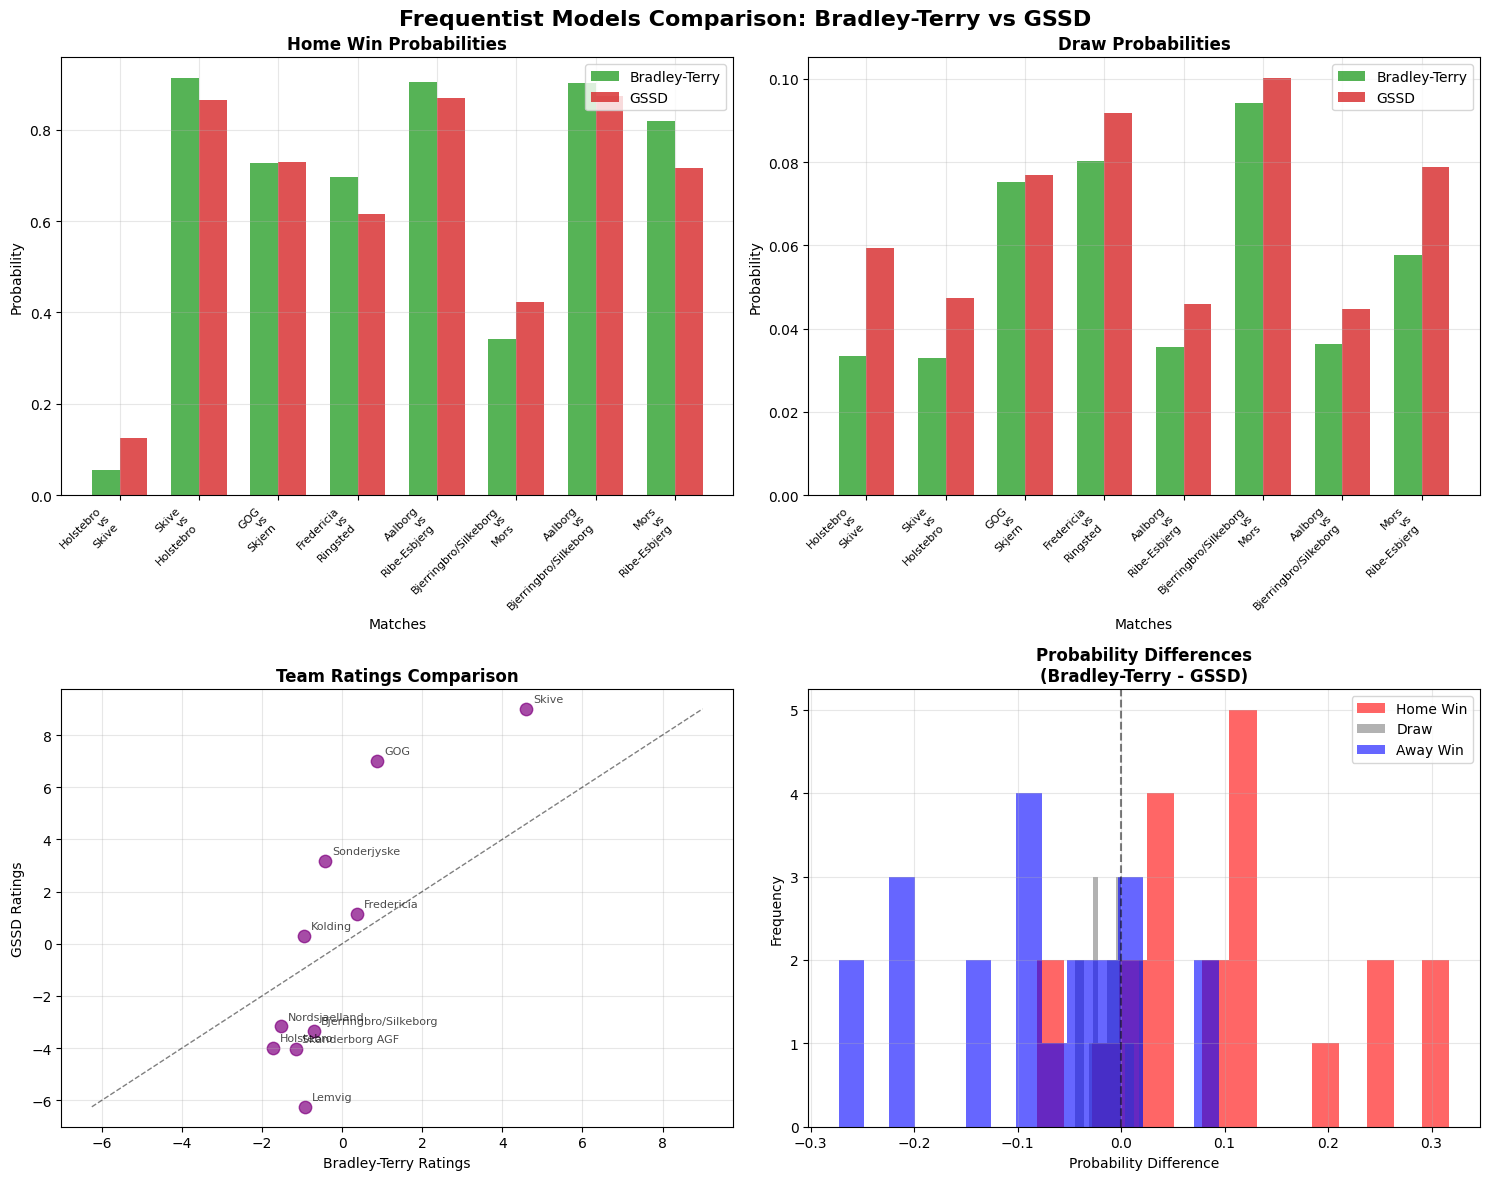


=== MODEL COMPARISON SUMMARY ===
Average Home Win Prob - Bradley-Terry: 0.632
Average Home Win Prob - GSSD: 0.535
Average Draw Prob - Bradley-Terry: 0.061
Average Draw Prob - GSSD: 0.075
Average Away Win Prob - Bradley-Terry: 0.308
Average Away Win Prob - GSSD: 0.391

Mean Absolute Difference (Home): 0.1123
Mean Absolute Difference (Draw): 0.0196
Mean Absolute Difference (Away): 0.1018


In [7]:
# Set up the plotting style
plt.style.use("default")
sns.set_palette("husl")

# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle(
    "Frequentist Models Comparison: Bradley-Terry vs GSSD",
    fontsize=16,
    fontweight="bold",
)

# Plot 1: Win Probabilities Comparison
ax1 = axes[0, 0]
test_subset = X_test_filtered.iloc[:8]  # Show first 8 test matches for clarity
bt_subset = bt_probas_filtered[:8]
gssd_subset = gssd_probas_filtered[:8]

x_pos = range(len(test_subset))
width = 0.35

ax1.bar(
    [x - width / 2 for x in x_pos],
    bt_subset[:, 0],  # home probabilities
    width,
    label="Bradley-Terry",
    alpha=0.8,
    color="#2ca02c",
)
ax1.bar(
    [x + width / 2 for x in x_pos],
    gssd_subset[:, 0],  # home probabilities
    width,
    label="GSSD",
    alpha=0.8,
    color="#d62728",
)

ax1.set_title("Home Win Probabilities", fontweight="bold")
ax1.set_xlabel("Matches")
ax1.set_ylabel("Probability")
ax1.set_xticks(x_pos)
ax1.set_xticklabels(
    [f"{row.home_team}\nvs\n{row.away_team}" for _, row in test_subset.iterrows()],
    rotation=45,
    ha="right",
    fontsize=8,
)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Draw Probabilities Comparison
ax2 = axes[0, 1]
ax2.bar(
    [x - width / 2 for x in x_pos],
    bt_subset[:, 1],  # draw probabilities
    width,
    label="Bradley-Terry",
    alpha=0.8,
    color="#2ca02c",
)
ax2.bar(
    [x + width / 2 for x in x_pos],
    gssd_subset[:, 1],  # draw probabilities
    width,
    label="GSSD",
    alpha=0.8,
    color="#d62728",
)

ax2.set_title("Draw Probabilities", fontweight="bold")
ax2.set_xlabel("Matches")
ax2.set_ylabel("Probability")
ax2.set_xticks(x_pos)
ax2.set_xticklabels(
    [f"{row.home_team}\nvs\n{row.away_team}" for _, row in test_subset.iterrows()],
    rotation=45,
    ha="right",
    fontsize=8,
)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Team Ratings Comparison
ax3 = axes[1, 0]
# Get common teams between both models
common_teams = set(bt_ratings.index) & set(gssd_team_ratings.index)
common_teams = list(common_teams)[:10]  # Show top 10 for clarity

if common_teams:
    bt_common = bt_ratings.loc[common_teams]["rating"]
    gssd_common = gssd_team_ratings.loc[common_teams]["rating"]

    ax3.scatter(bt_common, gssd_common, alpha=0.7, s=80, color="purple")

    # Add team labels
    for i, team in enumerate(common_teams):
        ax3.annotate(
            team,
            (bt_common[team], gssd_common[team]),
            xytext=(5, 5),
            textcoords="offset points",
            fontsize=8,
            alpha=0.7,
        )

    # Add diagonal line for reference
    min_val = min(bt_common.min(), gssd_common.min())
    max_val = max(bt_common.max(), gssd_common.max())
    ax3.plot([min_val, max_val], [min_val, max_val], "k--", alpha=0.5, linewidth=1)

ax3.set_title("Team Ratings Comparison", fontweight="bold")
ax3.set_xlabel("Bradley-Terry Ratings")
ax3.set_ylabel("GSSD Ratings")
ax3.grid(True, alpha=0.3)

# Plot 4: Probability Differences (Residuals)
ax4 = axes[1, 1]
prob_diff_home = bt_probas_filtered[:, 0] - gssd_probas_filtered[:, 0]  # home
prob_diff_draw = bt_probas_filtered[:, 1] - gssd_probas_filtered[:, 1]  # draw
prob_diff_away = bt_probas_filtered[:, 2] - gssd_probas_filtered[:, 2]  # away

ax4.hist(prob_diff_home, bins=15, alpha=0.6, label="Home Win", color="red")
ax4.hist(prob_diff_draw, bins=15, alpha=0.6, label="Draw", color="gray")
ax4.hist(prob_diff_away, bins=15, alpha=0.6, label="Away Win", color="blue")

ax4.axvline(x=0, color="black", linestyle="--", alpha=0.5)
ax4.set_title("Probability Differences\n(Bradley-Terry - GSSD)", fontweight="bold")
ax4.set_xlabel("Probability Difference")
ax4.set_ylabel("Frequency")
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n=== MODEL COMPARISON SUMMARY ===")
print(f"Average Home Win Prob - Bradley-Terry: {bt_probas_filtered[:, 0].mean():.3f}")
print(f"Average Home Win Prob - GSSD: {gssd_probas_filtered[:, 0].mean():.3f}")
print(f"Average Draw Prob - Bradley-Terry: {bt_probas_filtered[:, 1].mean():.3f}")
print(f"Average Draw Prob - GSSD: {gssd_probas_filtered[:, 1].mean():.3f}")
print(f"Average Away Win Prob - Bradley-Terry: {bt_probas_filtered[:, 2].mean():.3f}")
print(f"Average Away Win Prob - GSSD: {gssd_probas_filtered[:, 2].mean():.3f}")

print(f"\nMean Absolute Difference (Home): {abs(prob_diff_home).mean():.4f}")
print(f"Mean Absolute Difference (Draw): {abs(prob_diff_draw).mean():.4f}")
print(f"Mean Absolute Difference (Away): {abs(prob_diff_away).mean():.4f}")


 ## Additional Analysis



 Let's examine model characteristics and team rating distributions.

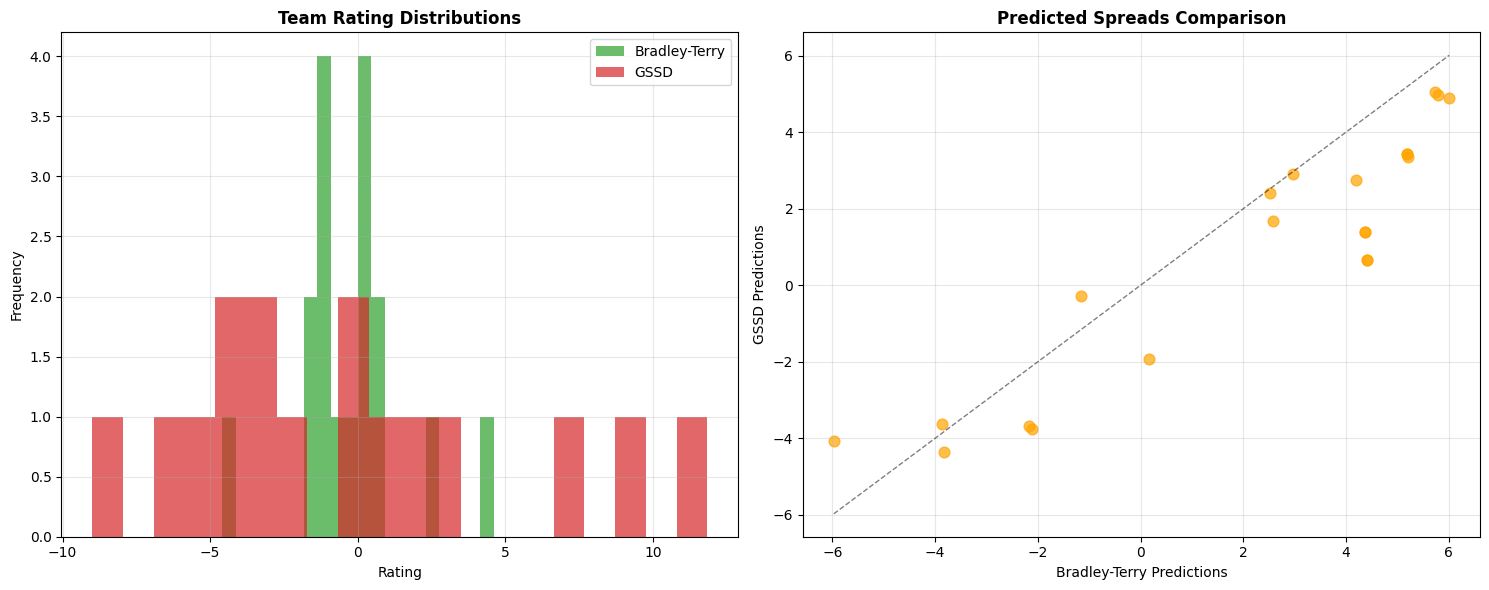

In [8]:
# Create additional analysis plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Team Rating Distributions
ax1 = axes[0]
if len(bt_ratings) > 0 and len(gssd_team_ratings) > 0:
    ax1.hist(
        bt_ratings["rating"], bins=20, alpha=0.7, label="Bradley-Terry", color="#2ca02c"
    )
    ax1.hist(
        gssd_team_ratings["rating"],
        bins=20,
        alpha=0.7,
        label="GSSD",
        color="#d62728",
    )
    ax1.set_title("Team Rating Distributions", fontweight="bold")
    ax1.set_xlabel("Rating")
    ax1.set_ylabel("Frequency")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

# Plot 2: Prediction Spread Comparison
ax2 = axes[1]
ax2.scatter(bt_preds_filtered, gssd_preds_filtered, alpha=0.7, s=60, color="orange")

# Add diagonal line for reference
min_pred = min(bt_preds_filtered.min(), gssd_preds_filtered.min())
max_pred = max(bt_preds_filtered.max(), gssd_preds_filtered.max())
ax2.plot([min_pred, max_pred], [min_pred, max_pred], "k--", alpha=0.5, linewidth=1)

ax2.set_title("Predicted Spreads Comparison", fontweight="bold")
ax2.set_xlabel("Bradley-Terry Predictions")
ax2.set_ylabel("GSSD Predictions")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


 ## Conclusion



 This notebook demonstrates proper evaluation of frequentist Bradley-Terry and Poisson models:



 **Model Performance:**

 - Used chronological train-test split to simulate real-world prediction scenarios

 - Evaluated prediction accuracy using MAE and RMSE metrics

 - Models trained on early matches, tested on later matches



 **Key Differences:**

 - **Bradley-Terry Model**: Logistic regression approach with team strength parameters, excellent for ranking

 - **GSSD Model**: Uses linear regression with team offensive/defensive statistics, provides detailed performance breakdown

 - **Team Ratings**: Bradley-Terry provides overall strength, GSSD separates offensive and defensive capabilities per location



 **Practical Advantages:**

 - Fast fitting compared to Bayesian approaches

 - Interpretable parameters and team ratings

 - Suitable for real-time applications and live betting

 - No sampling uncertainty - deterministic predictions